In [1]:
import json
from PIL import Image
import cv2
import numpy as np
import math
import os

## Jupyter Version

In [ ]:
import panoMosaics

In [ ]:
# vars for jupyter notebook

cwd = os.getcwd()  # current local dir
input_dir = cwd + "/data/"
output_dir = cwd + "/results/"

test_videos = [input_dir+"avis/"+file for file in os.listdir(input_dir+"avis/") if file[-4:]==".avi"]
print("Found Videos:\n", '\n '.join(test_videos))

test_boxes = [input_dir+"object_detection/"+file for file in os.listdir(input_dir+"object_detection/") if file[-5:]==".json"]
print("Found Boxes:\n", '\n '.join(test_boxes))

chunks_to_process = 15  # 85


main_frame_arr = panoMosaics.video_to_frame_arr(test_videos[2])

with open(test_boxes[2], 'r') as j:
     detic_dict = json.loads(j.read())
        
newpath = cwd+"/results/final_pano_frames/" 




Found Videos:
 /home/pari/Desktop/test/data/avis/2023.03.20-19.05.44-main.avi
 /home/pari/Desktop/test/data/avis/2023.04.11-17.25.01-main.avi
 /home/pari/Desktop/test/data/avis/2023.03.29-17.39.21-main.avi
Found Boxes:
 /home/pari/Desktop/test/data/object_detection/2023.03.20-19.05.44-detic:image.json
 /home/pari/Desktop/test/data/object_detection/2023.04.11-17.25.01-detic:image.json
 /home/pari/Desktop/test/data/object_detection/2023.03.29-17.39.21-detic:image.json


In [ ]:
#cell 2
#small example that worked for me with main_frame_arr from 2023.03.29-17.39.21-main.avi
indices = [50, 100, 150, 200]
background_width = 2280
background_height = 1284

if not os.path.exists(newpath):
    os.makedirs(newpath)

final_pano_frames = panoMosaics.stitch_one_at_a_time(indices, main_frame_arr, background_width, background_height)

/home/pari/miniconda3/envs/myenv/lib/python3.9/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'im_arr' of function 'alpha_composite_n_images_parallel'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../miniconda3/envs/myenv/lib/python3.9/site-packages/panoMosaics/pano_mosaic.py", line 368:
@njit(parallel=True)
def alpha_composite_n_images_parallel(im_arr):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


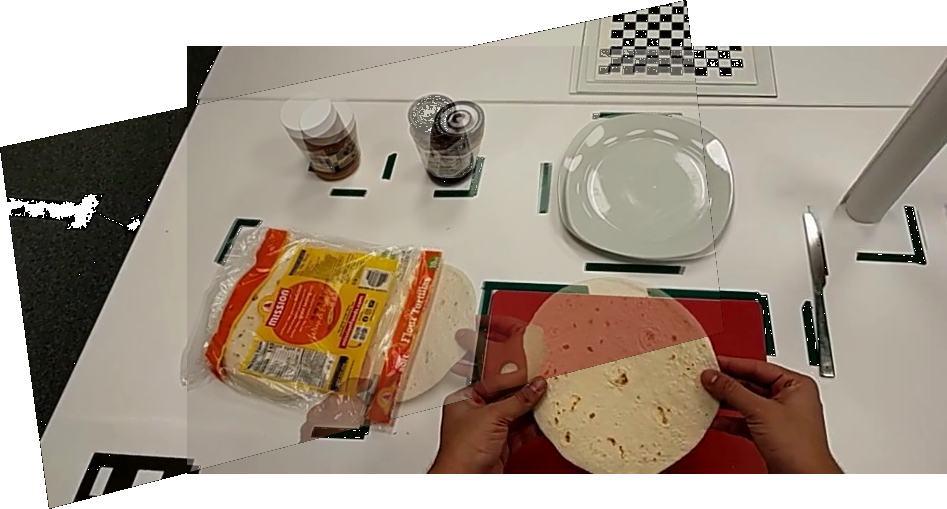

In [ ]:
#gets the # of seconds from start for each frame
frame_sfs_arr = []
sfs = 0
for i in range(len(main_frame_arr)):
  frame_sfs_arr.append(sfs)
  sfs = sfs + (1/15)

#have to match frames with timestamps (each frame needs to have a timestamp)
timestamps_sfs_arr = []
start_timestamp = detic_dict[0]["timestamp"]
for i in range(len(detic_dict)):
  current_timestamp = detic_dict[i]["timestamp"]
  sec_from_start = panoMosaics.get_sec_from_start(current_timestamp, start_timestamp)
  timestamps_sfs_arr.append(sec_from_start)

frames_timestamps_arr = []
arr = timestamps_sfs_arr
n = len(arr)
for i in range(len(main_frame_arr)):
  target = frame_sfs_arr[i]
  closest = panoMosaics.findClosest(arr, n, target)
  target_idx = timestamps_sfs_arr.index(closest)
  timestamp = detic_dict[target_idx]["timestamp"]
  frames_timestamps_arr.append(timestamp)


#stitch the panorama
src = main_frame_arr[160]
dst = main_frame_arr[200]
kp_src, des_src = panoMosaics.get_keypoints_descriptors(src)
kp_dst, des_dst = panoMosaics.get_keypoints_descriptors(dst)
matches = panoMosaics.feature_matching(des_src, des_dst)
transf = panoMosaics.get_homography_matrix(src, dst, kp_src, kp_dst, matches, 4)
src_list = [src]
transf_list = [transf]
dst_pad, warped_src_arr, new_transf_list, anchorX, anchorY = panoMosaics.warp_n_with_padding(dst, src_list, transf_list, 
                                                                                 main_frame_arr)
im_arr = panoMosaics.get_rgba_im_arr(dst_pad, warped_src_arr)
comp_arr = panoMosaics.alpha_composite_n_images_parallel(im_arr)

cv2.imwrite(newpath + "pano-nobox.png", comp_arr) # write to results folder
pil_img = Image.open(newpath+"pano-nobox.png")  # display
display(pil_img)


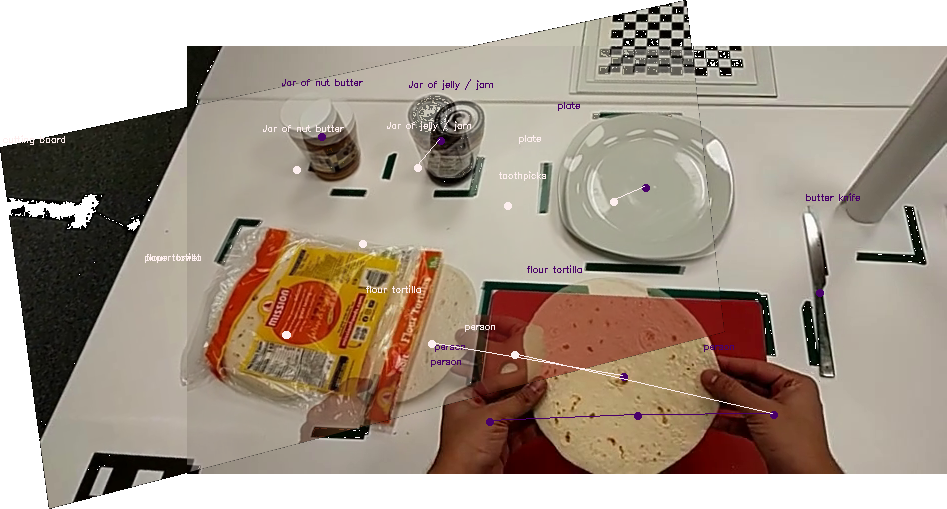

In [ ]:
#add bounding boxes
index_list = [200, 160]
frames_timestamps_arr = frames_timestamps_arr
detic_dict = detic_dict
panorama_image = comp_arr
new_transf_list = new_transf_list #list of homography matrices used to create panorama
anchorX = anchorX #anchorX and anchorY were calculated in the previous cell when generating the panorama
anchorY = anchorY

plasmaScale = ["#0d0887","#100788","#130789","#16078a","#19068c","#1b068d","#1d068e","#20068f","#220690","#240691","#260591","#280592","#2a0593","#2c0594","#2e0595","#2f0596","#310597","#330597","#350498","#370499","#38049a","#3a049a","#3c049b","#3e049c","#3f049c","#41049d","#43039e","#44039e","#46039f","#48039f","#4903a0","#4b03a1","#4c02a1","#4e02a2","#5002a2","#5102a3","#5302a3","#5502a4","#5601a4","#5801a4","#5901a5","#5b01a5","#5c01a6","#5e01a6","#6001a6","#6100a7","#6300a7","#6400a7","#6600a7","#6700a8","#6900a8","#6a00a8","#6c00a8","#6e00a8","#6f00a8","#7100a8","#7201a8","#7401a8","#7501a8","#7701a8","#7801a8","#7a02a8","#7b02a8","#7d03a8","#7e03a8","#8004a8","#8104a7","#8305a7","#8405a7","#8606a6","#8707a6","#8808a6","#8a09a5","#8b0aa5","#8d0ba5","#8e0ca4","#8f0da4","#910ea3","#920fa3","#9410a2","#9511a1","#9613a1","#9814a0","#99159f","#9a169f","#9c179e","#9d189d","#9e199d","#a01a9c","#a11b9b","#a21d9a","#a31e9a","#a51f99","#a62098","#a72197","#a82296","#aa2395","#ab2494","#ac2694","#ad2793","#ae2892","#b02991","#b12a90","#b22b8f","#b32c8e","#b42e8d","#b52f8c","#b6308b","#b7318a","#b83289","#ba3388","#bb3488","#bc3587","#bd3786","#be3885","#bf3984","#c03a83","#c13b82","#c23c81","#c33d80","#c43e7f","#c5407e","#c6417d","#c7427c","#c8437b","#c9447a","#ca457a","#cb4679","#cc4778","#cc4977","#cd4a76","#ce4b75","#cf4c74","#d04d73","#d14e72","#d24f71","#d35171","#d45270","#d5536f","#d5546e","#d6556d","#d7566c","#d8576b","#d9586a","#da5a6a","#da5b69","#db5c68","#dc5d67","#dd5e66","#de5f65","#de6164","#df6263","#e06363","#e16462","#e26561","#e26660","#e3685f","#e4695e","#e56a5d","#e56b5d","#e66c5c","#e76e5b","#e76f5a","#e87059","#e97158","#e97257","#ea7457","#eb7556","#eb7655","#ec7754","#ed7953","#ed7a52","#ee7b51","#ef7c51","#ef7e50","#f07f4f","#f0804e","#f1814d","#f1834c","#f2844b","#f3854b","#f3874a","#f48849","#f48948","#f58b47","#f58c46","#f68d45","#f68f44","#f79044","#f79143","#f79342","#f89441","#f89540","#f9973f","#f9983e","#f99a3e","#fa9b3d","#fa9c3c","#fa9e3b","#fb9f3a","#fba139","#fba238","#fca338","#fca537","#fca636","#fca835","#fca934","#fdab33","#fdac33","#fdae32","#fdaf31","#fdb130","#fdb22f","#fdb42f","#fdb52e","#feb72d","#feb82c","#feba2c","#febb2b","#febd2a","#febe2a","#fec029","#fdc229","#fdc328","#fdc527","#fdc627","#fdc827","#fdca26","#fdcb26","#fccd25","#fcce25","#fcd025","#fcd225","#fbd324","#fbd524","#fbd724","#fad824","#fada24","#f9dc24","#f9dd25","#f8df25","#f8e125","#f7e225","#f7e425","#f6e626","#f6e826","#f5e926","#f5eb27","#f4ed27","#f3ee27","#f3f027","#f2f227","#f1f426","#f1f525","#f0f724","#f0f921"]
RdPu = ["#fff7f3","#fff6f2","#fff6f2","#fff5f1","#fff4f0","#fff3f0","#fff3ef","#fff2ee","#fff1ed","#fef0ed","#fef0ec","#feefeb","#feeeeb","#feeeea","#feede9","#feece9","#feebe8","#feebe7","#feeae6","#fee9e6","#fee8e5","#fee8e4","#fee7e3","#fee6e3","#fee5e2","#fee5e1","#fde4e0","#fde3e0","#fde2df","#fde2de","#fde1dd","#fde0dd","#fddfdc","#fddedb","#fddeda","#fdddd9","#fddcd8","#fddbd8","#fddad7","#fddad6","#fdd9d5","#fdd8d4","#fdd7d4","#fdd6d3","#fdd5d2","#fdd5d1","#fdd4d0","#fdd3cf","#fcd2cf","#fcd1ce","#fcd0cd","#fccfcc","#fccecb","#fccecb","#fccdca","#fcccc9","#fccbc8","#fccac8","#fcc9c7","#fcc8c6","#fcc7c5","#fcc6c5","#fcc5c4","#fcc4c3","#fcc3c3","#fcc2c2","#fcc1c2","#fcc0c1","#fcbfc0","#fcbec0","#fcbdbf","#fbbbbf","#fbbabe","#fbb9be","#fbb8bd","#fbb7bd","#fbb6bc","#fbb5bc","#fbb3bb","#fbb2bb","#fbb1bb","#fbb0ba","#fbafba","#fbadb9","#fbacb9","#fbabb8","#fba9b8","#faa8b7","#faa7b7","#faa5b7","#faa4b6","#faa3b6","#faa1b5","#faa0b5","#fa9fb4","#fa9db4","#fa9cb3","#fa9ab3","#fa99b2","#fa97b2","#f996b1","#f994b1","#f993b0","#f991b0","#f98faf","#f98eaf","#f98cae","#f98bae","#f989ad","#f887ac","#f886ac","#f884ab","#f882ab","#f881aa","#f87faa","#f77ea9","#f77ca9","#f77aa8","#f778a7","#f677a7","#f675a6","#f673a6","#f572a5","#f570a5","#f56ea4","#f46da4","#f46ba3","#f369a3","#f368a2","#f266a2","#f264a2","#f163a1","#f161a1","#f05fa0","#f05ea0","#ef5c9f","#ee5a9f","#ee599f","#ed579e","#ec559e","#ec549d","#eb529d","#ea509c","#e94f9c","#e94d9c","#e84c9b","#e74a9b","#e6489a","#e5479a","#e4459a","#e34399","#e24299","#e14098","#e03e98","#df3d97","#de3b97","#dd3a96","#dc3896","#db3695","#da3595","#d93394","#d83294","#d63093","#d52e92","#d42d92","#d32b91","#d12a91","#d02890","#cf268f","#ce258f","#cc238e","#cb228d","#ca208d","#c81f8c","#c71d8b","#c51c8b","#c41b8a","#c31989","#c11889","#c01788","#be1588","#bd1487","#bb1386","#ba1286","#b81185","#b70f84","#b50e84","#b40d83","#b20c83","#b10b82","#af0b82","#ae0a81","#ac0981","#aa0880","#a90780","#a7077f","#a6067f","#a4067e","#a3057e","#a1057e","#9f047d","#9e047d","#9c037c","#9b037c","#99037c","#97037b","#96027b","#94027b","#93027a","#91027a","#8f027a","#8e017a","#8c0179","#8b0179","#890179","#870178","#860178","#840178","#830178","#810177","#7f0177","#7e0177","#7c0176","#7b0176","#790176","#780175","#760175","#740175","#730174","#710174","#700174","#6e0173","#6d0173","#6b0173","#690172","#680172","#660172","#650171","#630171","#620070","#600070","#5f0070","#5d006f","#5b006f","#5a006e","#58006e","#57006e","#55006d","#54006d","#52006c","#51006c","#4f006c","#4e006b","#4c006b","#4b006a","#49006a"]
colors_list = RdPu  # ["#ff0000d9", "#00ff00d9"] = [red, green]
thickness = 2 
#set with class ids of objects to show, optional argument to draw_all_bounding_boxes, if no argument is sent it is initialised as empty and when the subset is empty, all objects are highlighted 
object_subset= []
pano_with_bounding_boxes = panoMosaics.draw_all_bounding_boxes_for_given_indices(index_list, frames_timestamps_arr, 
                                                                     detic_dict, panorama_image, new_transf_list, 
                                                                     anchorX, anchorY, colors_list, thickness, 'center_dot_lined', object_subset)

cv2.imwrite(newpath + "pano-withbox.png", pano_with_bounding_boxes)
pil_img = Image.open(newpath+"pano-withbox.png")
display(pil_img)


## Google Colaboratory Version

In [ ]:
!pip install git+https://github.com/egm68/panoramic-mosaics

In [3]:
import panoMosaics
from google.colab.patches import cv2_imshow

In [5]:
#main_frame_arr = panoMosaics.get_demo_video_data() 
#detic_dict = panoMosaics.get_demo_detic_data()

main_frame_arr = panoMosaics.video_to_frame_arr('/content/2023.03.29-17.39.21-main.avi')
        
with open('/content/2023.03.29-17.39.21-detic:image.json', 'r') as j:
     detic_dict = json.loads(j.read())

newpath = "/content/final_pano_frames/" 

In [6]:
#gets the # of seconds from start for each frame
frame_sfs_arr = panoMosaics.get_sfs_arr(main_frame_arr)

#have to match frames with timestamps (each frame needs to have a timestamp)
timestamps_sfs_arr = panoMosaics.get_timestamp_arr(detic_dict)
frames_timestamps_arr = panoMosaics.get_frame_timestamps_arr(main_frame_arr, detic_dict, frame_sfs_arr, timestamps_sfs_arr)

Generating clip with classic bounding boxes:

In [7]:
#get clip used in use case section of report
clip_frame_arr = main_frame_arr[160:205]
#draw classic bounding boxes
output_frame_arr = panoMosaics.classic_bounding_boxes(clip_frame_arr, detic_dict, frames_timestamps_arr, [160,205])
panoMosaics.save_to_video(output_frame_arr, 15, '/content/panorama-classic-bounding-boxes.mp4')

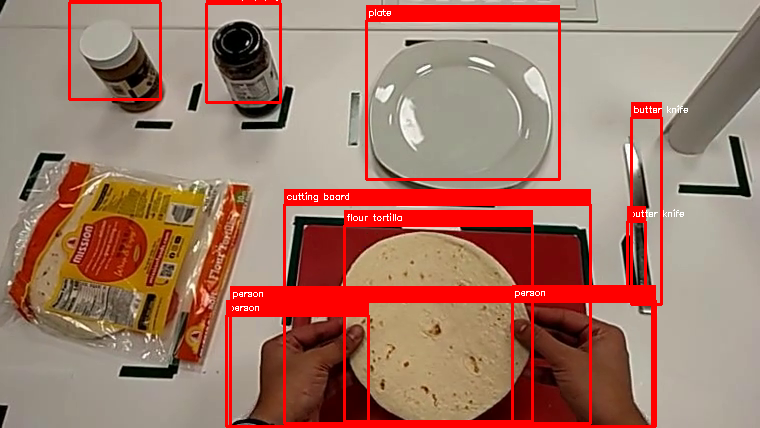

In [16]:
cv2_imshow(output_frame_arr[44])

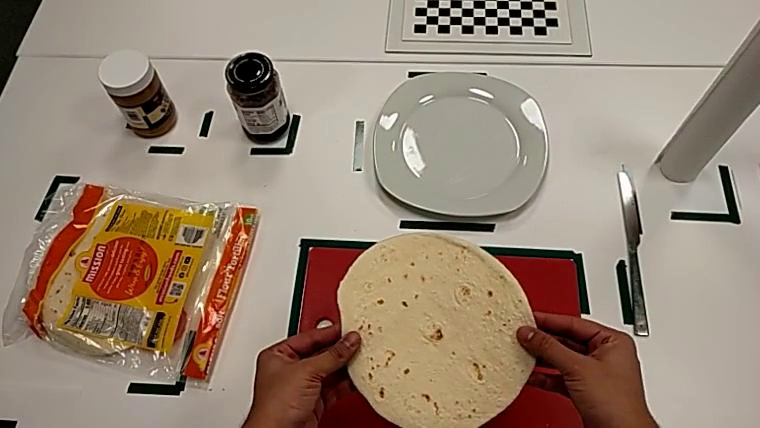

In [21]:
cv2_imshow(main_frame_arr[196])

Stitch panoramic mosaic:

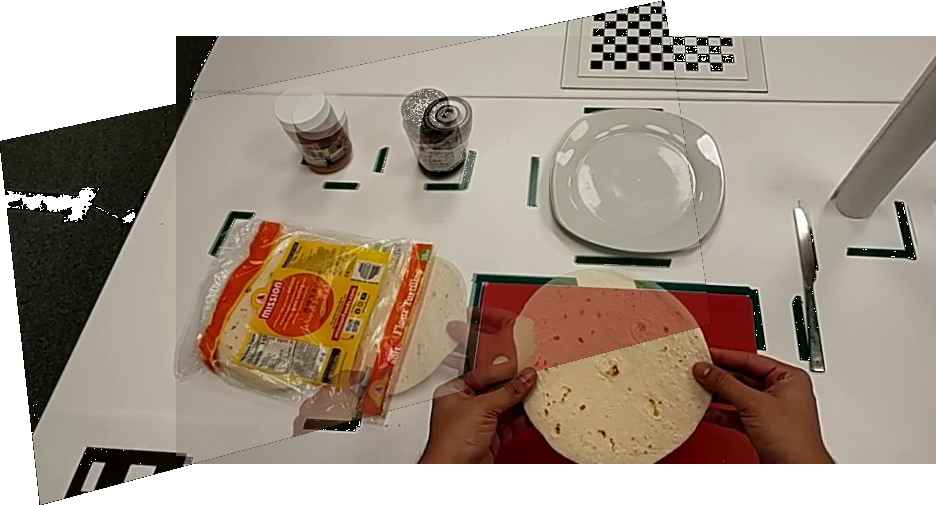

In [ ]:
#stitch the panorama
#src_list = [main_frame_arr[160], main_frame_arr[169], main_frame_arr[178], main_frame_arr[187]]
#src_index_list = [160, 169, 178, 187]
src_list = [main_frame_arr[160]]
src_index_list = [160]
dst = main_frame_arr[196]
kp_dst, des_dst = panoMosaics.get_keypoints_descriptors(dst)
transf_list = []

for i in range(len(src_list)):
  kp_src, des_src = panoMosaics.get_keypoints_descriptors(src_list[i])
  matches = panoMosaics.feature_matching(des_src, des_dst)
  transf = panoMosaics.get_homography_matrix(src_list[i], dst, kp_src, kp_dst, matches, 4)
  transf_list.append(transf)

dst_pad, warped_src_arr, new_transf_list, anchorX, anchorY = panoMosaics.warp_n_with_padding(dst, src_list, transf_list, 
                                                                                 main_frame_arr)
im_arr = panoMosaics.get_rgba_im_arr(dst_pad, warped_src_arr)
comp_arr = panoMosaics.alpha_composite_n_images_parallel(im_arr)

transf_index_dict = {}
for i in range(len(src_index_list)):
  transf_index_dict[src_index_list[i]] = new_transf_list[i]

cv2.imwrite("/content/pano-nobox.png", comp_arr) # write to results folder
cv2_imshow(comp_arr)

Add object detection output:

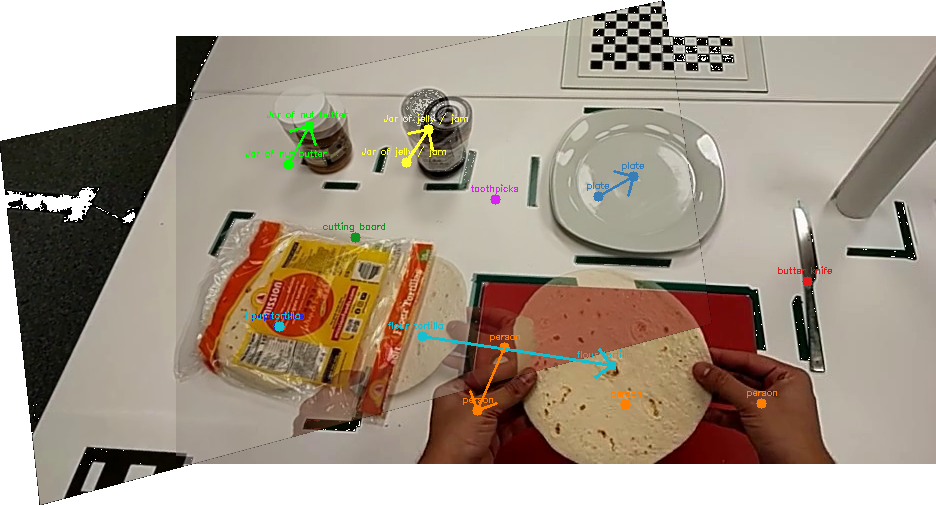

In [ ]:
#add bounding boxes
#index_list = [160, 169, 178, 187, 196]
index_list = [160, 196]
dst_index = 196
frames_timestamps_arr = frames_timestamps_arr
detic_dict = detic_dict
panorama_image = comp_arr
anchorX = anchorX 
anchorY = anchorY
colors_list = ["#e41a1c","#377eb8","#d920f5","#ff7f00","#ffff33", "#00ff00d9", "#17becf", "#2323d9", '#0e9620']
color_scheme = "object" #options: object" or "time"
thickness = 2 
box_type = 'center_dot_lined_updated' #options: 'box', 'side_box', 'center_dot', 'center_dot_lined_updated', 'frame', 'corner_dot'

#set with class ids of objects to show, optional argument to draw_all_bounding_boxes, if no argument is sent it is initialised as empty and when the subset is empty, all objects are highlighted 
object_subset= []

pano_with_bounding_boxes = panoMosaics.draw_all_bounding_boxes_for_given_indices(index_list, frames_timestamps_arr, 
                                                                     detic_dict, panorama_image, transf_index_dict, dst_index,
                                                                     anchorX, anchorY, colors_list, color_scheme, thickness, box_type, object_subset)

cv2.imwrite("/content/pano-withbox.png", pano_with_bounding_boxes)
cv2_imshow(pano_with_bounding_boxes)